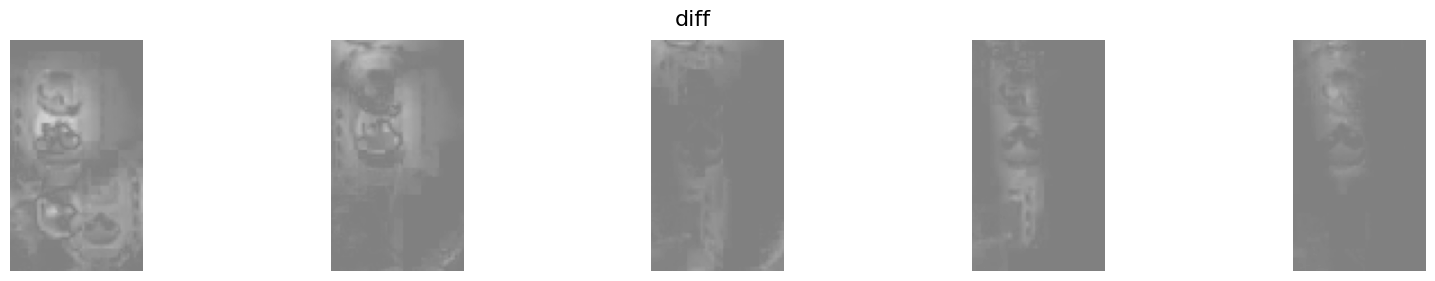

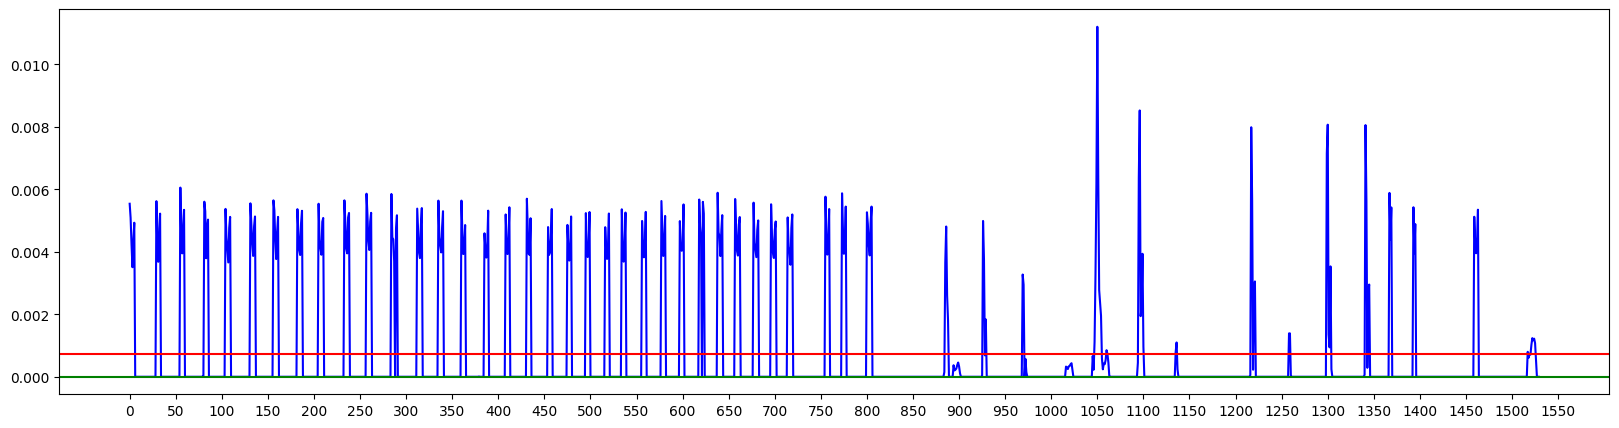

0
28
54
80
104
131
156
182
204
232
256
283
311
334
359
384
407
430
453
474
494
515
533
555
576
596
618
638
656
676
695
714
754
772
800
1366
1392
1458
38


<Figure size 2000x500 with 0 Axes>

In [26]:
# 動画から自フィールドのツモ部分のみの画像を生成する。
from os import major
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys

# 動画読み込み
cap = cv2.VideoCapture("./resources/puyo_battle.mp4")

fps = cap.get(cv2.CAP_PROP_FPS)
w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
sec = frame_count / fps

# fps, frame_count, round(sec, 3), (h, w)

frame_st = 1050
frame_ed = 1055

# 動画から画像を抽出
n_frames = int(51 * fps + 1)
frames = []
while True:
    # generator にしたほうが使いやすい
    ret, frame = cap.read()
    if not ret:
        print("read error")
        break

    frames.append(frame[35: 138, 256: 315])
    if len(frames) == n_frames:
        break

# グレースケール変換
gray_frames = [cv2.cvtColor(f, cv2.COLOR_BGR2GRAY) for f in frames]
gray_frame_range = gray_frames[frame_st:frame_ed]
gray_frame_range2 = gray_frames[frame_st+1:frame_ed+ 1]

# フレーム間の差分を求める。
for bef, aft in zip(gray_frame_range, gray_frame_range2):
    diff_frame = cv2.absdiff(aft, bef)

# 差分出力
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
for bef, aft, ax in zip(gray_frame_range, gray_frame_range2, axes):
    diff_frame = cv2.absdiff(aft, bef)
    ax.imshow(diff_frame, cmap="gray", vmin=-255, vmax=255)
    ax.axis("off")

_ = fig.suptitle("diff", fontsize=16)

# 全フレームの差分を計算
diff_frames = [cv2.absdiff(aft, bef) for bef, aft in zip(gray_frames, gray_frames[1:])]
# 2値化して計算しやすくする。
th = 30 # しきい値
for i, x in enumerate(diff_frames):
    x[x < th] = 0
    x[x >= th] = 1
    diff_frames[i] = x
n_diff_pixels = (diff_frames[0] != 0).sum()


fig = plt.figure(figsize=(20, 5))
area = w * h # １フレームのピクセル数
# フレーム間の変化率を計算 
# ※１フレームのピクセル数と「２値化した変化ピクセル？」から変化率を求める
# Maxは1, Minは0
diff_rates = np.array([(d != 0).sum() / area for d in diff_frames])

# 変化率の平均
mean = diff_rates.mean()
# 変化率の中央値
median = np.median(diff_rates)

plt.plot(diff_rates, color="blue", label="rate")
plt.axhline(mean, color="red", label="avg")
_ = plt.axhline(median, color="green", label="median")

ax=plt.gca()
# 数字が表示される目盛り
ax.set_xticks(np.arange(0, 1600, 50))
# サブ目盛り
# ax.set_xticks(np.arange(0, 1600, 25), minor=True)

plt.show()


fig = plt.figure(figsize=(20, 5))
tumos = []

max = 0.0065
min = 0.0035
max_tumo_frame_range = 6

a = -1

# フレーム間で全く変わらない場合があるのでその考慮
# 連続していない0は消す。
hairetu = []
next = 1
for i, x in enumerate(diff_rates):
    if diff_rates.size == i + 1:
        break
    if diff_rates[i] == 0 and diff_rates[i+1] != 0:
        diff_rates[i] = diff_rates[i+1]
        
# ツモ判定
for i, x in enumerate(diff_rates):
    if x == 0 or i <= a:
        continue
    frame_no = i
    
    next_zero_frame = np.where(diff_rates[i:] == 0)[0][0] + i
    
    range_frame = np.array(diff_rates[frame_no: next_zero_frame])
    result = range_frame[np.where((range_frame>min) & (range_frame<max))]
    
    first = range_frame[0]
    end = range_frame[-1]
    mannaka = range_frame[int(range_frame.size / 2)]
    
    max_value = range_frame.max()
    
    value = max_value * (3 / 4)
    
    # size = range_frame[range_frame > min & range_frame < max].size
    # print(result.size)
    if result.size >= 3 and mannaka < value:
        print(i)
        a = i + result.size
        tumos.append(i)

print(len(tumos))
# mul_tbl = [1 for y in range(0, len(tumos))]
# plt.plot(tumos, mul_tbl, color="blue", label="rate")

# ax=plt.gca()
# # 数字が表示される目盛り
# ax.set_xticks(np.arange(0, 1600, 50))